In [1]:
%matplotlib inline 
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

import re

### Define functions

In [2]:

def load_fasta(fasta_file,sites_of_interest):
    """
    Load a fasta file into a pandas dataframe.
    
    fasta_file: fasta file (aligned, single line per sequence)
    sites_of_interest: dictionary where indexes are position in alignment
                       sequence (starting at 0) and values are sequence number
                       in amino acid sequence.
    
    returns df
    """

    # Read fasta file into a numpy array
    names = []
    sequences = []
    with open(fasta_file) as f:
        for line in f:
            if line.startswith(">"):
                names.append(line[1:].strip())
                sequences.append([])
                continue

            sequences[-1].extend([c for c in line.strip()])

    sequences = np.array(sequences)

    # Create array of sequences containing only columns for sites of interest
    slicer = np.array(list(sites_of_interest.keys()),dtype=int)


    sequences = sequences[:,slicer]

    # Dict to use as source for data frame
    to_pd = {}
    to_pd["name"] = names
    to_pd["paralog"] = [n.split("|")[0] for n in names]

    # Load columns for sites of interest into dict
    for i in range(len(slicer)):
        to_pd[f"site_{sites_of_interest[slicer[i]]}"] = [s for s in sequences[:,i]]

    return pd.DataFrame(to_pd)

def classify_and_color(df):
    """
    Classify amino acids in dataframe and update dataframe. 
    
    Returns df, aa_to_class dictionary and class_to_color dictionary
    """

    # Create dictionary mapping amino acid name to amino acid class
    membership = [(["K","R","H"],"basic","pink"),
                  (["E","D"],"acidic","firebrick"),
                  (["F","W","Y"],"aromatic","yellow"),
                  (["S","T","N","Q","C"],"polar","pink"),
                  (["A","I","L","V","M"],"hphobic","gray"),
                  (["P"],"pro","pink"),
                  (["G"],"gly","pink"),
                  (["-","X"],"gap","pink")]

    aa_to_class = {}
    class_to_color = {}
    for i in range(len(membership)):
        for aa in membership[i][0]:
            aa_to_class[aa] = membership[i][1]
            class_to_color[membership[i][1]] = membership[i][2]

    for col in list(df.columns):
        if not col.startswith("site_"):
            continue

        class_col = []
        for aa in df.loc[:,col]:
            class_col.append(aa_to_class[aa])
        df[f"class_{col}"] = class_col

    return df, aa_to_class, class_to_color


def get_top_n_classes(count_dict,n=2):
    """
    Grab the most common n classes from a sequence dataframe and return the
    class values and their counts.
    """
    
    sorted_keys = [(count_dict[k],k) for k in count_dict]
    sorted_keys.sort(reverse=True)
    sorted_keys = dict([(v[1],i) for i, v in enumerate(sorted_keys[:n])])
    
    return sorted_keys



### Do calculation

MRP-126
0.000000000395456
hphobic hphobic 71
hphobic aromatic 0
aromatic hphobic 24
aromatic aromatic 19
expected number of aro/aro: 7.167

S100A12
1.000000000000000
aromatic hphobic 71
aromatic aromatic 41
hphobic hphobic 3
hphobic aromatic 1
expected number of aro/aro: 40.552

S100A8
0.069844849293053
aromatic hphobic 61
aromatic aromatic 24
hphobic hphobic 2
hphobic aromatic 4
expected number of aro/aro: 26.154

S100A9
0.000003437929734
hphobic aromatic 74
hphobic hphobic 19
aromatic aromatic 2
aromatic hphobic 12
expected number of aro/aro: 9.944




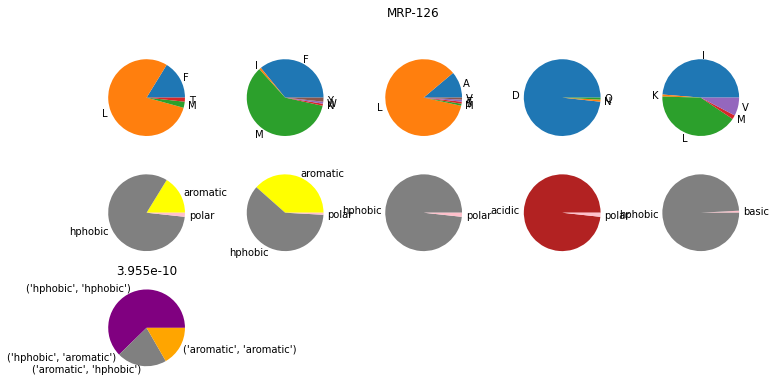

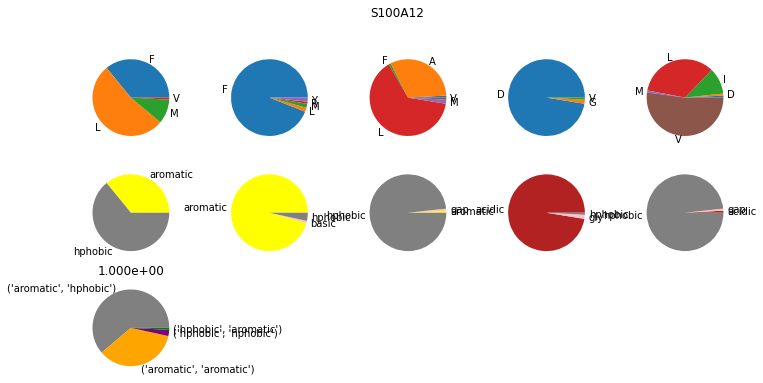

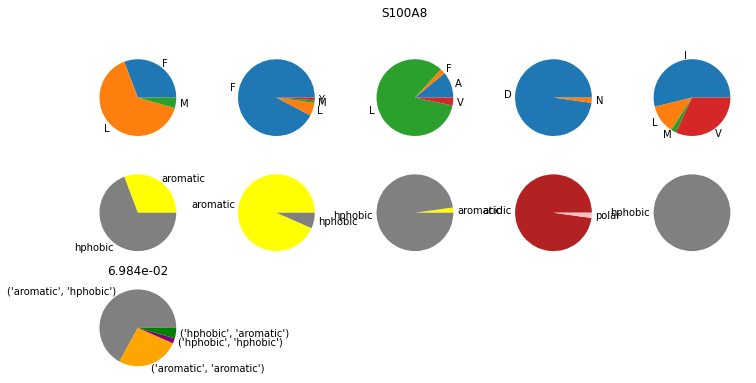

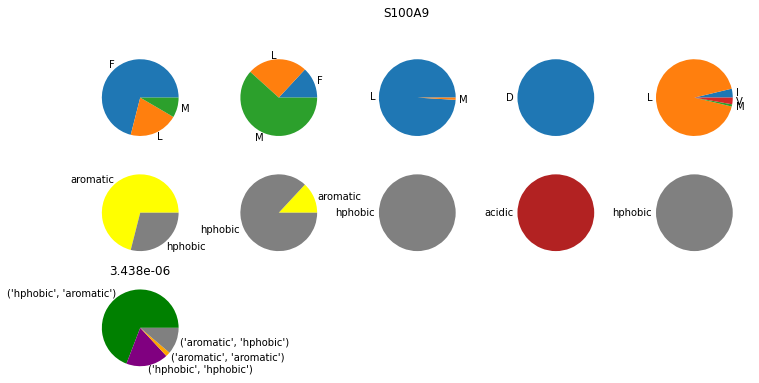

In [3]:

# Load the alignment into the dataframe
df = load_fasta(fasta_file="alignment.fasta",
                sites_of_interest={174:37,204:63,207:66,208:67,215:74})

# Classify amino acids in dataframe
df, aa_to_class, class_to_color = classify_and_color(df)

# We're interested in site 63
focal_site = 63

# Colors for output pie charts showing coincidence of amino acids 
coincidence_colors = {("hphobic","aromatic"):"green",
                      ("aromatic","aromatic"):"orange",
                      ("aromatic","hphobic"):"gray",
                      ("hphobic","hphobic"):"purple"}

out = []

# For every paralog in the alignment
for para in np.unique(df.paralog):
    
    out.append(f"{para}\n")
    
    # Grab rows corresponding to this paralog
    rows = df.loc[df.paralog == para,:]
    
    # Get top two classes of amino acids observed at the focal site
    obs, counts = np.unique(rows.loc[:,f"class_site_{focal_site}"],return_counts=True)
    focal_class_dict = dict(zip(obs,counts))
    focal_classes = get_top_n_classes(focal_class_dict,2)

    # Create a figure object
    fig, ax = plt.subplots(3,
                           len([c for c in df.columns if c.startswith("site_")]),
                           figsize=(12,6))
    fig.suptitle(para)
    
    # Go through columns
    counter = 0
    for col in df.columns:
        
        # Skip non site_ columns
        if not col.startswith("site_"):
            continue

        # Create pie chart with counts for all amino acids
        obs, counts = np.unique(rows.loc[:,col],return_counts=True)
        count_dict = dict(zip(obs,counts))
        ax[0,counter].pie(count_dict.values(),labels=count_dict.keys())
        
        # Create pie chart with counts for all amino acid classes
        obs, counts = np.unique(rows.loc[:,f"class_{col}"],return_counts=True)
        class_dict = dict(zip(obs,counts))        
        local_classes = get_top_n_classes(class_dict,n=2)
        ax[1,counter].pie(class_dict.values(),labels=class_dict.keys(),
                  colors=[class_to_color[c] for c in class_dict.keys()])
        
        # If this is not site 37, don't make a coincidence pie chart
        if col != "site_37":
            ax[2,counter].axis("off")
            counter +=1
            continue
        
        # Get classes seen for focal (63) and local (37) site
        focal = list(rows.loc[:,f"class_site_{focal_site}"])
        local = list(rows.loc[:,f"class_{col}"])
        
        # Make a contigency table for these classes between sites 63 and 37
        table = np.zeros((2,2),dtype=int)
        for i in range(len(rows)):
            if focal[i] in focal_classes.keys() and local[i] in local_classes.keys():
                table[local_classes[local[i]],focal_classes[focal[i]]] += 1
                
        # Run fisher's exact test on contingency table
        p_value = stats.fisher_exact(table)[1]
        out.append(f"{p_value:.15f}\n")

        # Create a dictionary mapping this table to human-readable names
        coincidence_pie = {}
        for x in focal_classes:
            for y in local_classes:
                out.append(f"{x} {y} {table[local_classes[y],focal_classes[x]]}\n")
                coincidence_pie[(x,y)] = table[local_classes[y],focal_classes[x]]
        
        # Calculate expected number of aro/aro pairs
        site_37_aro = 0
        site_63_aro = 0
        all_seen = 0
        for k in coincidence_pie:
            if k[0] == "aromatic":
                site_37_aro += coincidence_pie[k]
            if k[1] == "aromatic":
                site_63_aro += coincidence_pie[k]

            all_seen += coincidence_pie[k]

        E = all_seen*(site_37_aro/all_seen * site_63_aro/all_seen)
        out.append(f"expected number of aro/aro: {E:.3f}\n")
    
        # Figure out coloring for the coincidence pie chart
        colors = []
        for k in coincidence_pie.keys():
            try:
                colors.append(coincidence_colors[k])
            except KeyError:
                colors.append("black")
        
        # Plot coincidence pie chart
        ax[2,counter].pie(coincidence_pie.values(),labels=coincidence_pie.keys(),colors=colors)
        ax[2,counter].set_title(f"{p_value:.3e}")
        
        counter +=1 
        
    out.append("\n")
        
    plt.savefig(f"{para}.pdf")

print("".join(out))
f = open('output-stats.txt','w')
f.write("".join(out))
f.close()
    